# Portfolio
- Goals
    - Utilise different machine learnign models to train the financial data and build portfolio of stocks
- Data
    - Preprocess in path "data/~"
    - The data include five table from TEJ database, which include ~ 

## 1. Data and Import 

In [2]:
""" 
# in colab
!pip install optuna
# mount
from google.colab import drive
drive.mount('/content/drive')
# path
os.chdir('/content/drive/MyDrive/portfolio/data')
import sys
sys.path.append(sys.path[0] + f"/drive/MyDrive/portfolio") # current path + ~
# data
with open(f"{sys.path[-1]}/data/{industry}/data4model.pickle", "rb") as f:
    data = pickle.load(f)
"""

' \n# in colab\n!pip install optuna\n# mount\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\n# path\nos.chdir(\'/content/drive/MyDrive/portfolio/data\')\nimport sys\nsys.path.append(sys.path[0] + f"/drive/MyDrive/portfolio") # current path + ~\n# data\nwith open(f"{sys.path[-1]}/data/{industry}/data4model.pickle", "rb") as f:\n    data = pickle.load(f)\n'

In [1]:
%load_ext autoreload
%autoreload 2
# Preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc, pickle, warnings

from train import summary
from utils import *
warnings.filterwarnings('ignore')

# data
industry = "automobile"
with open(f"data/{industry}/data4model.pickle", "rb") as f:
    data = pickle.load(f)

# preprocess; most preprocess are done in data file, eg. standardise, ...
data = data.reset_index()
data["ymd"] = pd.to_datetime(data["ymd"], format="%Y-%m-%d")
data = data.set_index(["code", "ymd"])

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##  2. Train

### 2.1 Build porfolio and rolling prediciton

In [2]:

models = \
        {
        1: "linear",
        2: "elastic net",
        3: "decision tree", 
        4: "random forest", 
        5: "xgboost", 
        6: "svm",
        7: "neural network",
        8: "ensemble", 
        }

model_config = \
        {
        "industry": "automobile",
        "train_size": 5,    
        "test_size": 1,     
        "test_start": 2021,  

        "long_bound": 80,       
        "short_bound": 20,        
        "ls_decision": ["test", "no running"],
        "n_trials": 20,      
        "tune": True,
        "do_short": True, 
        "input_size": 89   
        }



In [3]:
for i in models:
    if i < 8:
        model_name = models[7]
        portfolio = summary(model_name, data, **model_config)
        portfolio.rolling_prediction()
        break

[I 2024-01-04 09:16:53,716] A new study created in memory with name: no-name-3d2334fc-4218-4db6-b368-21bc47a361b1


param: {'batch_size': 25}
===> tune start


[I 2024-01-04 09:18:06,760] Trial 0 finished with value: -0.0001928785932250321 and parameters: {'n_layers': 2, 'active': False, 'hidden_nodes0': 236, 'hidden_nodes1': 54, 'optimizer': 'Adam', 'lr': 0.06065438040091731, 'epochs': 263, 'reg_coef': 0.015827047333810396, 'scheduler': 'None'}. Best is trial 0 with value: -0.0001928785932250321.
[I 2024-01-04 09:19:50,842] Trial 1 finished with value: -0.00019556253391783684 and parameters: {'n_layers': 9, 'active': True, 'hidden_nodes0': 397, 'hidden_nodes1': 203, 'hidden_nodes2': 260, 'hidden_nodes3': 158, 'hidden_nodes4': 234, 'hidden_nodes5': 293, 'hidden_nodes6': 254, 'hidden_nodes7': 433, 'hidden_nodes8': 116, 'optimizer': 'RMSprop', 'lr': 0.004724569212477594, 'epochs': 259, 'reg_coef': 6.375295179249559e-05, 'scheduler': 'None'}. Best is trial 0 with value: -0.0001928785932250321.
[I 2024-01-04 09:21:38,125] Trial 2 finished with value: -0.0017426584381610155 and parameters: {'n_layers': 5, 'active': True, 'hidden_nodes0': 158, 'hid

{'n_layers': 3, 'active': False, 'hidden_nodes0': 507, 'hidden_nodes1': 291, 'hidden_nodes2': 512, 'optimizer': 'Adam', 'lr': 0.014028223588786543, 'epochs': 237, 'reg_coef': 0.014352201032427615, 'scheduler': 'None'}
===> training start


[I 2024-01-04 09:38:04,693] A new study created in memory with name: no-name-9f4bbaf4-4e8c-401e-a79f-0df966be048d


2021-02-01 00:00:00
   performance        ymd
0     0.006847 2021-01-11
param: {'batch_size': 25}
===> tune start


[I 2024-01-04 09:39:05,810] Trial 0 finished with value: -0.034770891070365906 and parameters: {'n_layers': 5, 'active': True, 'hidden_nodes0': 320, 'hidden_nodes1': 436, 'hidden_nodes2': 289, 'hidden_nodes3': 510, 'hidden_nodes4': 372, 'optimizer': 'SGD', 'lr': 3.525427744366741e-05, 'epochs': 274, 'reg_coef': 2.8908290605613024e-05, 'scheduler': 'None'}. Best is trial 0 with value: -0.034770891070365906.
[I 2024-01-04 09:39:15,354] Trial 1 finished with value: -0.028669580817222595 and parameters: {'n_layers': 3, 'active': True, 'hidden_nodes0': 464, 'hidden_nodes1': 291, 'hidden_nodes2': 405, 'optimizer': 'SGD', 'lr': 1.4486181391515172e-05, 'epochs': 170, 'reg_coef': 0.00954961329114549, 'scheduler': 'None'}. Best is trial 1 with value: -0.028669580817222595.
[I 2024-01-04 09:39:29,258] Trial 2 finished with value: -0.05036933347582817 and parameters: {'n_layers': 8, 'active': True, 'hidden_nodes0': 211, 'hidden_nodes1': 217, 'hidden_nodes2': 289, 'hidden_nodes3': 489, 'hidden_node

{'n_layers': 1, 'active': False, 'hidden_nodes0': 18, 'optimizer': 'RMSprop', 'lr': 0.0043040221089741615, 'epochs': 242, 'reg_coef': 0.0005694216283950401, 'scheduler': 'None'}
===> training start


[I 2024-01-04 09:47:10,777] A new study created in memory with name: no-name-24a24475-432c-4513-a5f8-b6723dfc5acf


2021-03-01 00:00:00
   performance        ymd
0     0.048632 2021-02-09
param: {'batch_size': 25}
===> tune start


[I 2024-01-04 09:47:40,754] Trial 0 finished with value: -0.0001965215924428776 and parameters: {'n_layers': 6, 'active': True, 'hidden_nodes0': 46, 'hidden_nodes1': 383, 'hidden_nodes2': 420, 'hidden_nodes3': 187, 'hidden_nodes4': 356, 'hidden_nodes5': 478, 'optimizer': 'RMSprop', 'lr': 0.00029198425715898417, 'epochs': 253, 'reg_coef': 0.0012269342384910035, 'scheduler': 'None'}. Best is trial 0 with value: -0.0001965215924428776.
[I 2024-01-04 09:47:52,441] Trial 1 finished with value: -0.00018754783377517015 and parameters: {'n_layers': 7, 'active': False, 'hidden_nodes0': 357, 'hidden_nodes1': 112, 'hidden_nodes2': 311, 'hidden_nodes3': 391, 'hidden_nodes4': 137, 'hidden_nodes5': 212, 'hidden_nodes6': 202, 'optimizer': 'RMSprop', 'lr': 8.861926208967166e-05, 'epochs': 221, 'reg_coef': 0.002275857773356741, 'scheduler': 'None'}. Best is trial 1 with value: -0.00018754783377517015.
[I 2024-01-04 09:49:06,012] Trial 2 finished with value: -0.00014348715194500983 and parameters: {'n_l

Ensemble method

In [20]:
# Ensemble method

# add all result from models
for i in models:
    if i < 8:
        model_name = models[i]
        performance_rolling, rplsw_rolling, market_rolling  = \
            models_get_result(industry, model_name, model_config) 
    else:
        break
    if i == 1:
        rplsw_rolling_ensem = rplsw_rolling
    else:
        rplsw_rolling_ensem["pred_ls"] += rplsw_rolling["pred_ls"]


rplsw_rolling_ensem.reset_index(inplace=True)

In [43]:
# backtest returns for ensemble
def ensem_backtest(rplsw_rolling_ensem):
    rplsw_rolling_ensem = rplsw_rolling_ensem.copy()
    long = rplsw_rolling_ensem[rplsw_rolling_ensem["pred_ls"] >= 3]
    short = rplsw_rolling_ensem[rplsw_rolling_ensem["pred_ls"] <= -3]

    if len(long) != 0 and len(short) != 0:
        long_rate = .5
        short_rate = .5
    elif len(long) != 0 and len(short) == 0:
        long_rate = 1
        short_rate = 0
    elif len(long) == 0 and len(short) != 0:
        long_rate = 0
        short_rate = 1
    else:
        print("No long or short")
        return 0

    long["ensem_weight"] = (long["pred_ls"] / long["pred_ls"].sum())*long_rate
    short["ensem_weight"] = (short["pred_ls"] / short["pred_ls"].sum())*short_rate
    print(f"check weight: {long['ensem_weight'].sum() + short['ensem_weight'].sum()}")
    ensem_return = (long["ensem_weight"]*long["return"]).sum() - (short["ensem_weight"]*short["return"]).sum()
    return ensem_return

ensem_returns = {}
for date in rplsw_rolling_ensem["ymd"].unique():
    ensem_returns[date] = ensem_backtest(rplsw_rolling_ensem[rplsw_rolling_ensem["ymd"] == date])

plt.plot(np.cumprod([i + 1 for i in list(ensem_returns.values())]))
m = np.mean(list(ensem_returns.values()))*12
v = np.std(list(ensem_returns.values()))*(12**(1/2))
m, v, m/v

check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 0.9999999999999999
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0
check weight: 1.0


### 2.2 Backtest
`# subplots vs subplot?`
- result in
    - result/industry/
    - result/industry/train_size_year_?

In [4]:
# Check if short success
model_name = models[7]
performance_rolling, rplsw_rolling, market_rolling  = \
    models_get_result(industry, model_name, model_config) 
(rplsw_rolling["pred_ls"] == -1).sum()

202

market performance ==================
market_mean: 0.1384795173451961, market_vol: 0.19459484931267879
market: sharpe ratio 0.7116299215231772


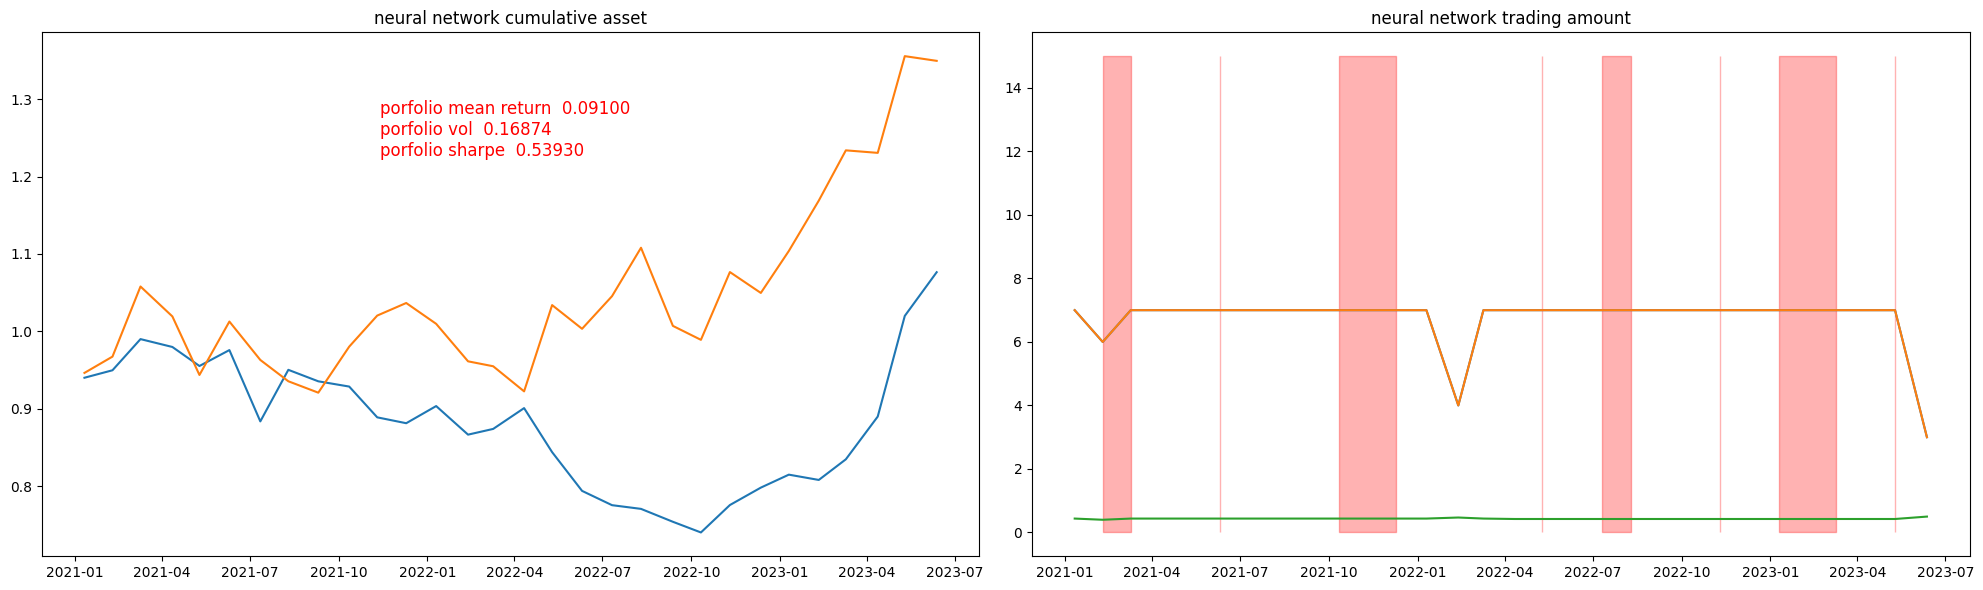

In [5]:
industry = "automobile"
models = {1: "linear",
         2: "elastic net",
         3: "decision tree", 
         4: "random forest", 
         5: "xgboost", 
         6: "svm", 
         7: "neural network",
         8: "ensemble",
         }

model_config = \
        {
        "industry": "automobile",
        "train_size": 5,    
        "test_size": 1,     
        "test_start": 2021,  

        "long_bound": 80,       
        "short_bound": 20,        
        "ls_decision": ["test", "no running"],
        "n_trials": 5,      
        "tune": True,
        "do_short": True, 
        "input_size": 89   # = input size | original dimension = input_size: 89
        }

for i in models:
    if i < 8:
        model_name = models[7]
        plot_model_result(industry, model_name, model_config)
        # performance_rolling rplsw_rolling, market_rolling, = \
        #    models_get_result(industry, model_name, model_config)        
        # n_long, n_short, trading_rate = trading(rplsw_rolling)
        break